In [1]:
#Libraries
import pandas as pd
import pandas as pd
from surprise import Reader, Dataset, SVDpp, accuracy, PredictionImpossible
from collections import defaultdict
from surprise.model_selection import KFold
from random import shuffle
import matplotlib.pyplot as plt

#Importing the data
data = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/df_oversamling.csv')
data.head()

,userId,wine,rate
0,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Montepulciano 60,1
1,4e0cbfe3-8d73-4af4-b09e-f3193d1170a5,Zahorra Blanca,1
2,20e0b694-84a5-4f11-9191-598f924c2947,Morellino di Scansano 2021,1
3,20e0b694-84a5-4f11-9191-598f924c2947,Morellino di Scansano 2021,1
4,5ccd8030-047b-432c-a630-d784ab415756,Bardolino Chiaretto,1


In [2]:
#metrics
metrics_df = pd.DataFrame(
    columns=['Index','Model','RMSE','MAE','MSE', 'Precision', 'Recall', 'Accuracy'])
print(metrics_df)

Empty DataFrame
Columns: [Index, Model, RMSE, MAE, MSE, Precision, Recall, Accuracy]
Index: []


In [3]:
class Svdpp (SVDpp):
    def __init__(self, n_factors, n_epochs, lr_all, reg_all, verbose):
       SVDpp.__init__(self, 
                    n_factors= n_factors, n_epochs = n_epochs,
                    lr_all= lr_all, 
                    reg_all= reg_all, verbose = verbose)
    
    def create_reader(self, data):
        reader = Reader(rating_scale=(1, 5))
        self.data = Dataset.load_from_df(data[['userId', 'wine', 'rate']], reader)
        
    def fit (self):
        '''Divide the data into train and test manually '''
        #Frist shuffle the data
        raw_ratings = self.data.raw_ratings
        shuffle(raw_ratings)
        
        #75% of the data for training and the rest for testing
        threshold = int(.80 * len(raw_ratings))
        train_raw_ratings = raw_ratings[:threshold]
        test_raw_ratings = raw_ratings[threshold:]
        
        #Update the data object with train raw ratings
        self.data.raw_ratings = train_raw_ratings
        
        #Define a cross-validation iterator
        kf = KFold(n_splits=5, shuffle= True, random_state=42)
        
        train_rmse_list = []
        test_rmse_list = []
        
        for trainset_fold, testset_fold in kf.split(self.data):
            #Train and test algorithm.
            SVDpp.fit(self, trainset_fold)
            train_prediction = SVDpp.test(self, trainset_fold.build_testset())
            prediction = SVDpp.test(self, testset_fold)

            #Error on training
            train_rmse = accuracy.rmse(train_prediction)
            train_rmse_list.append(train_rmse)

            #Error on testing
            test_rmse = accuracy.rmse(prediction)
            test_rmse_list.append(test_rmse)

        avg_train_rmse = sum(train_rmse_list) / len(train_rmse_list)
        avg_test_rmse = sum(test_rmse_list) / len(test_rmse_list)
        print("###############################################")
        print("The Results are: \n")
        print(f"Average RMSE on Training Set: {avg_train_rmse}")
        print(f"Average RMSE on Test Set: {avg_test_rmse}")

        #Predict ratings for all pairs (u, i) that are NOT in the training set.
        #Update the data object with test raw ratings
        self.data.raw_ratings = test_raw_ratings
        #adapting the Testset to be compatible with Surprise
        testset = self.data.construct_testset(self.data.raw_ratings)
        #Predicting the ratings for testset
        predictions = SVDpp.test(self, testset)
        #RMSE
        test_rmse = accuracy.rmse(predictions)
        print(f"RMSE on Test Set on UNSEEN DATA is RMSE, : {test_rmse}")

        self.sim = self.compute_similarities()
        self.bu, self.bi = self.compute_baselines()
        return predictions
    
    def get_user_name(self, uid):
        """Return the name of a user from their id.
        Args:
            uid(int): The raw id of the user.
        Returns:
            The name of the user.
        """
        return self.trainset.to_raw_uid(uid)
    
    def get_item_name(self, iid):
        """Return the name of an item from their id.
        Args:
            iid(int): The raw id of the item.
        Returns:
            The name of the item.
        """
        return self.trainset.to_raw_iid(iid)
    
    def get_neighbors_uid(self, user_id, k=10):
        '''Return the k nearest neighbors of user_id'''
        neighbor_ids = self.get_neighbors(user_id, k=10)
        neighbor_names = [self.get_user_name(uid) for uid in neighbor_ids]
        return neighbor_names
    def get_neighbors_iid(self, item_id, k=10):
        '''Return the k nearest neighbors of item_id'''
        neighbor_ids = self.get_neighbors(item_id, k=10)
        neighbor_names = [self.get_item_name(iid) for iid in neighbor_ids]
        return neighbor_names
        
    def get_top_n_for_user(self, predictions,user_id, n=10):
        """Return the top-N recommendation for a user from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            n(int): The number of recommendation to output for each user. Default
                is 10.

        Returns:
        A dict where keys are user (raw) ids and values are lists of tuples:
            [(raw item id, rating estimation), ...] of size n.
        """

        # First map the predictions to each user.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if uid == user_id:
                top_n[uid].append((iid, est))

        # Then sort the predictions for the user and retrieve the k highest ones.
        user_ratings = top_n[user_id]
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[user_id] = user_ratings[:n]

        return top_n[user_id]
    
    def get_top_n_users_for_item(self, predictions, item_id, n=10):
        """Return the top-N users for a specific item from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            item_id: The id of the item for which to get the top-N users.
            n(int): The number of users to output for the item. Default is 10.

        Returns:
        A list of tuples:
            [(raw user id, rating estimation), ...] of size n.
        """

        # First map the predictions to each item.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if iid == item_id:
                top_n[iid].append((uid, est))

        # Then sort the predictions for the item and retrieve the k highest ones.
        item_ratings = top_n[item_id]
        item_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[item_id] = item_ratings[:n]

        return top_n[item_id]

    def estimated(self, u, i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible("User and/or item is unknown.")
        
        #Compute similarities between u and v, where v describes all other
        #users that have also rated item i.
        neighbors = [(v, self.sim[u, v]) for (v, r) in self.trainset.ir[i]]
        # Sort these neighbors by similarity
        neighbors = sorted(neighbors, key=lambda x: x[1], reverse=True)

        print("The 5 nearest neighbors of user", str(u), "are:")
        for v, sim_uv in neighbors[:5]:
            print(f"user {v} with sim {sim_uv:1.15f}")

        # ... Aaaaand return the baseline estimate anyway ;)
        bsl = self.trainset.global_mean + self.bu[u] + self.bi[i]
        return print(f"And the baseline estimate is: {bsl}")
    
    def get_Iu(self, uid):
        """Return the number of items rated by given user
        args:
          uid: the id of the user
        returns:
          the number of items rated by the user
        """
        try:
            return len(self.trainset.ur[self.trainset.to_inner_uid(uid)])
        except ValueError:  # user was not part of the trainset
            return 0

    def get_Ui(self, iid):
        """Return the number of users that have rated given item
        args:
          iid: the raw id of the item
        returns:
          the number of users that have rated the item.
        """
        try:
            return len(self.trainset.ir[self.trainset.to_inner_iid(iid)])
        except ValueError:
            return 0

    def inspect_predictions(self, predictions):
        print(f"uid means the user id and iid means the wine id\n")
        print(f"rui means the actual rating and est means the estimated rating\n")
        print(f"err means the error between the actual and the estimated rating\n")
        print(f"Iu means the number of items rated by given user\n")
        print(f"Ui means the number of users that have rated given item\n")
        # Create a dataframe with the predictions
        df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
        df_pred['Iu'] = df_pred.uid.apply(self.get_Iu)
        df_pred['Ui'] = df_pred.iid.apply(self.get_Ui)
        df_pred['err'] = abs(df_pred.est - df_pred.rui)
        return df_pred
    
    def get_accuracy(self, predictions, k=10, threshold=3.5):
        #Compute RMSE
        rmse = accuracy.rmse(predictions, verbose=True)
        #Compute MAE
        mae = accuracy.mae(predictions, verbose=True)
        # Compute MSE
        mse = accuracy.mse(predictions, verbose=True)

        #Compute precision and recall
        precisions, recalls = self.precision_recall_at_k(predictions, k=k, threshold=threshold)

        #Precision and recall can then be averaged over all users
        precision = sum(prec for prec in precisions.values()) / len(precisions)
        recall = sum(rec for rec in recalls.values()) / len(recalls)
        print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}')

        #Count correct predictions
        correct = 0
        for uid, iid, true_r, est, _ in predictions:
            if round(est) == round(true_r):
                correct += 1

        #Compute accuracy
        accuracy_percentage = correct / len(predictions)
        accuracy_percentage = accuracy_percentage * 100
        print(f"the acc is {accuracy_percentage:.2f}")

        #Return a dictionary with the metrics
        return {'RMSE': rmse, 'MAE': mae, 'MSE': mse, 'Precision': precision, 'Recall': recall, 'Accuracy': accuracy_percentage}
        
    @staticmethod 
    def precision_recall_at_k(predictions, k=10, threshold=3.5):
        """Return precision and recall at k metrics for each user"""
        # First map the predictions to each user.
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():
            # Sort user ratings by estimated value
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            # Number of relevant items
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            # Number of recommended items in top k
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

            # Number of relevant and recommended items in top k
            n_rel_and_rec_k = sum(
                ((true_r >= threshold) and (est >= threshold))
                for (est, true_r) in user_ratings[:k]
            )

            # Precision@K: Proportion of recommended items that are relevant
            # When n_rec_k is 0, Precision is undefined. We here set it to 0.
            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

            # Recall@K: Proportion of relevant items that are recommended
            # When n_rel is 0, Recall is undefined. We here set it to 0.
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        return precisions, recalls

## SVD++

The minimization is performed by a very straightforward stochastic gradient descent:
* note You can choose to use an unbiased version of this algorithm
* verbose – If True, prints the current epoch. Default is False.

In [4]:
#Setting the algorithm parameter by default:
svdpp = Svdpp(n_factors= 20, n_epochs= 20,  lr_all=0.007, reg_all=0.02 , verbose=False)

svdpp.create_reader(data)
predictions = svdpp.fit()
#acc
metrics = svdpp.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 1
metrics['Model'] = 'Singular Value Decomposition ++'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

RMSE: 0.3436
RMSE: 0.6624
RMSE: 0.3720
RMSE: 0.5898
RMSE: 0.3726
RMSE: 0.5343
RMSE: 0.3710
RMSE: 0.6110
RMSE: 0.3691
RMSE: 0.6328
###############################################
The Results are: 

Average RMSE on Training Set: 0.3656482206783954
Average RMSE on Test Set: 0.6060499876300975
RMSE: 0.6004
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.6004444345329951
RMSE: 0.6004
MAE:  0.4014
MSE: 0.3605
Precision: 0.33
Recall: 0.30
the acc is 70.34


/tmp/ipykernel_22586/1754958186.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


In [5]:
#Setting the algorithm parameter by default:
svdpp2 = Svdpp(n_factors= 20, n_epochs= 20,  lr_all=0.07, reg_all=0.02 , verbose=False)

svdpp2.create_reader(data)
predictions = svdpp2.fit()
#acc
metrics = svdpp2.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 2
metrics['Model'] = 'Singular Value Decomposition ++'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

RMSE: 0.1722
RMSE: 0.4721
RMSE: 0.1746
RMSE: 0.5033
RMSE: 0.1144
RMSE: 0.5835
RMSE: 0.1802
RMSE: 0.5277
RMSE: 0.1806
RMSE: 0.5134
###############################################
The Results are: 

Average RMSE on Training Set: 0.16441488840380974
Average RMSE on Test Set: 0.5200282043599659
RMSE: 0.5030
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.5029783277360457
RMSE: 0.5030
MAE:  0.2671
MSE: 0.2530
Precision: 0.36
Recall: 0.34
the acc is 78.48


/tmp/ipykernel_22586/524815810.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


In [6]:
metrics_df.sort_values(by='RMSE', ascending=True, inplace=True)
metrics_df

,Index,Model,RMSE,MAE,MSE,Precision,Recall,Accuracy
1,2,Singular Value Decomposition ++,0.502978,0.267066,0.252987,0.360861,0.339014,78.477690
0,1,Singular Value Decomposition ++,0.600444,0.401360,0.360534,0.331325,0.303203,70.341207


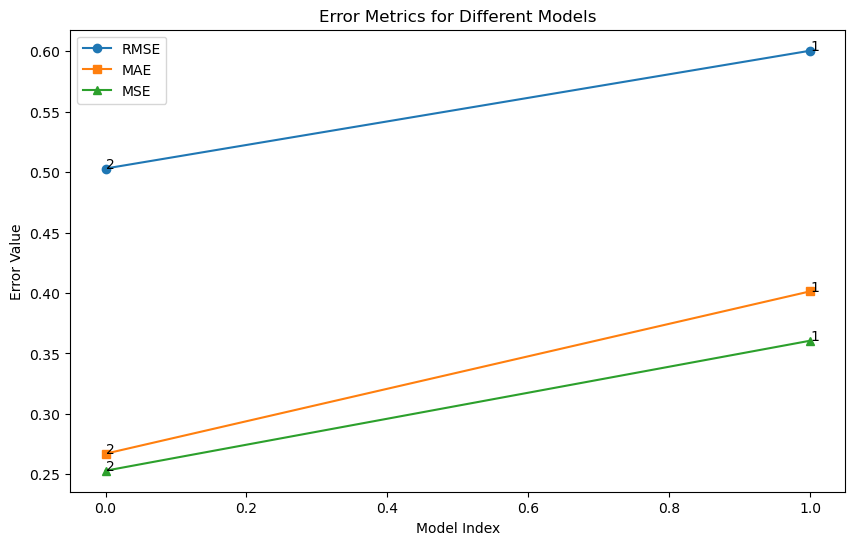

In [7]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MAE'], marker='s', linestyle='-', label='MAE')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MSE'], marker='^', linestyle='-', label='MSE')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MAE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MSE'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

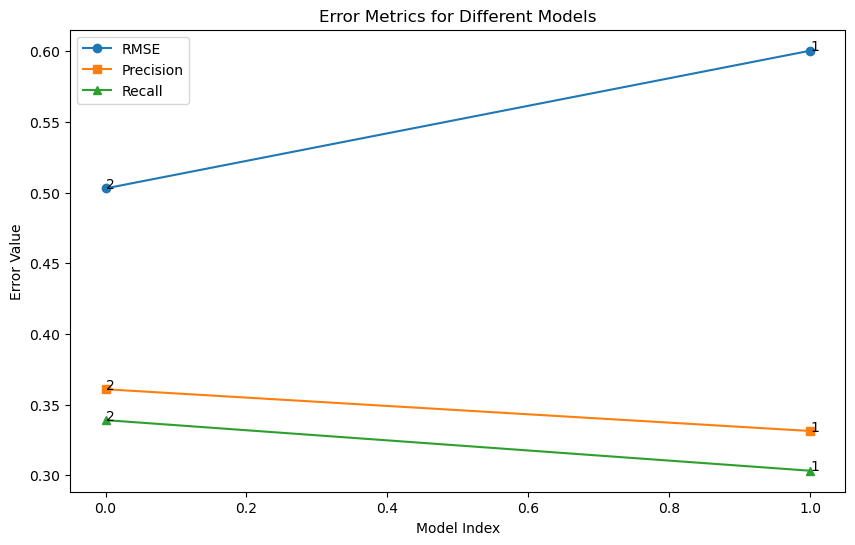

In [8]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Precision'], marker='s', linestyle='-', label='Precision')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Recall'], marker='^', linestyle='-', label='Recall')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Precision'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Recall'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

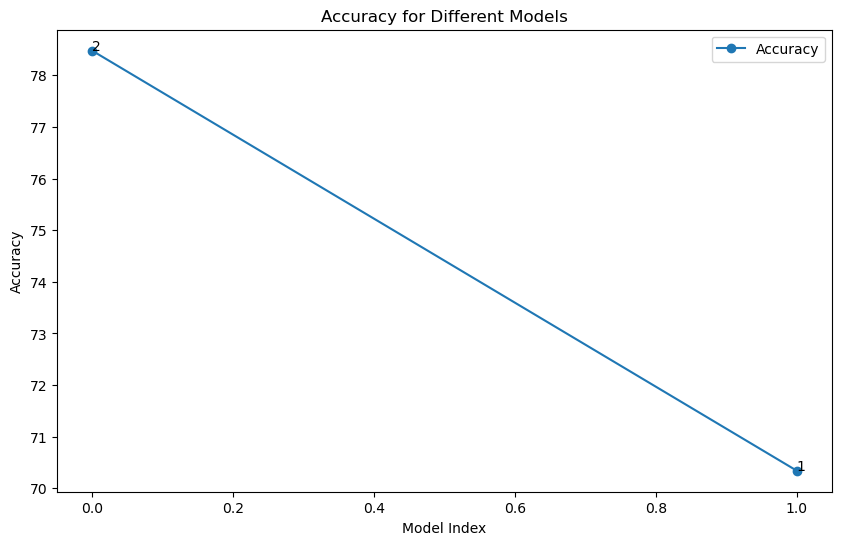

In [9]:
plt.figure(figsize=(10, 6))

#Plot Accuracy with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Accuracy'], marker='o', linestyle='-', label='Accuracy')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Accuracy'].iloc[i]))

#Setting title and labels
plt.title('Accuracy for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Accuracy')

#legend
plt.legend()
plt.show()

## Estimates

In [10]:
#recommends items for a given user from predictions

# user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
# top_n = KnnWithMeans.get_top_n_for_user(predictions, user_id)
# print(user_id, [iid for (iid, _) in top_n])
######### better print
user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
top_n = svdpp.get_top_n_for_user(predictions, user_id)
print(f"Top items for the user '{user_id}' are:")
for i, (iid, _) in enumerate(top_n, 1):
    print(f"{i}. Item ID: {iid}")

Top items for the user '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7' are:
1. Item ID: Le Relais de Patache d'Aux
2. Item ID: Chenin Blanc Secateurs
3. Item ID: Senorino de Baldios
4. Item ID: Chenin Blanc Secateurs
5. Item ID: Les 4 Terres
6. Item ID: LFE900
7. Item ID: Groot Constantia
8. Item ID: Groot Constantia
9. Item ID: Yellow Label 
10. Item ID: Lodi California


In [11]:
# recommneds users for a given item from predictions

# item_id = 'Chardonnay'
# top_n = KnnWithMeans.get_top_n_users_for_item(predictions, item_id)
# print(item_id, [uid for (uid, _) in top_n])
########## better print
item_id = 'Chardonnay'
top_n = svdpp.get_top_n_users_for_item(predictions, item_id)
print(f"Top users for the item '{item_id}' are:")
for i, (uid, _) in enumerate(top_n, 1):
    print(f"{i}. User ID: {uid}")

Top users for the item 'Chardonnay' are:
1. User ID: 36fec3ea-e183-491d-b65a-6c7ac90fafa5
2. User ID: 5ccd8030-047b-432c-a630-d784ab415756
3. User ID: d48fd3bd-06e9-4368-97b9-aae545388325
4. User ID: c88644be-2c9b-42f0-9c4b-7f8e81795f43


In [12]:
#get the KnnWithMeans for a user from the model
svdpp.get_neighbors_uid(user_id=5)

['47edd867-4e96-411a-b436-970e5f750b03',
 '8d43f723-f1e6-42ae-9e08-484403d2f5a3',
 '9a3cc655-c88e-4c1b-95e2-add7579ff4c2',
 '5ccd8030-047b-432c-a630-d784ab415756',
 '76b71bb0-6cc9-4168-8a45-bbafc1e9a256',
 'a0ef6b50-093e-4ae1-8e3c-58a2a17d2bb8',
 '13016d41-00bd-411c-83f5-2b95691696b7',
 'c88644be-2c9b-42f0-9c4b-7f8e81795f43',
 '9c85a219-a94e-4b78-b300-ea65e52e9c6e',
 '902db46c-a5bf-4d52-acd6-067a2bf3b876']

In [13]:
#get the KnnWithMeans for an item from the model
svdpp.get_neighbors_iid(item_id=20)

['2/5 大亂鬥 2',
 'Blauer Wildbacher',
 'P’tit Piaf Rouge',
 'Morellino di Scansano 2021',
 'Sandgrube 13 Grüner Veltliner',
 'Vistamar Cabernet Sauvignon Reserva',
 'The Hassar Grill Anniversary Blend',
 'Auxerrois Brut',
 '3/11 Syrah and blend #3',
 'Riesling Classic']

In [14]:
svdpp.estimated(13,20)
print('\n#####\n')
print("Note: If the baseline is {} then the value is a default value, Otherwise not".format(svdpp.trainset.global_mean))

The 5 nearest neighbors of user 13 are:
user 13 with sim 1.000000000000000
user 13 with sim 1.000000000000000
user 13 with sim 1.000000000000000
user 13 with sim 1.000000000000000
user 13 with sim 1.000000000000000
And the baseline estimate is: 2.7679096541528736

#####

Note: If the baseline is 2.987704918032787 then the value is a default value, Otherwise not


In [15]:
df_pred = svdpp.inspect_predictions(predictions)
best_pred = df_pred.sort_values(by='err')[:10]
worst_pred = df_pred.sort_values(by='err')[-10:]
df_pred.head(10)

uid means the user id and iid means the wine id

rui means the actual rating and est means the estimated rating

err means the error between the actual and the estimated rating

Iu means the number of items rated by given user

Ui means the number of users that have rated given item



,uid,iid,rui,est,details,Iu,Ui,err
0,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Graham's Block 7,3.0,3.040263,{'was_impossible': False},133,3,0.040263
1,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Nero d'Avola Lorlando,3.0,3.003692,{'was_impossible': False},133,0,0.003692
2,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Il mattaglio brut,5.0,4.960152,{'was_impossible': False},133,2,0.039848
3,bc8f3005-c2c6-4277-9fd7-340248f4e7ec,Vitovska acciaio,3.0,3.690056,{'was_impossible': False},12,4,0.690056
4,13016d41-00bd-411c-83f5-2b95691696b7,Vitovska acciaio,4.0,3.901940,{'was_impossible': False},20,4,0.098060
5,4e9cb62e-a165-484b-ad78-cb215523cdd5,Le sol,5.0,4.986106,{'was_impossible': False},3,3,0.013894
6,bc79b0e3-064d-4240-86de-e86499f577e8,2／17 @home #5,5.0,4.954738,{'was_impossible': False},92,1,0.045262
7,bc79b0e3-064d-4240-86de-e86499f577e8,3／4 大亂鬥 2,5.0,4.981678,{'was_impossible': False},92,2,0.018322
8,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Merlot,2.0,2.039991,{'was_impossible': False},64,10,0.039991
9,be0e69e3-30d5-4e21-b62f-05402fbfcd5a,Château Haut Bommes Sauternes,4.0,3.433674,{'was_impossible': False},4,1,0.566326


* best predictions

In [16]:
best_pred

,uid,iid,rui,est,details,Iu,Ui,err
39,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,le vigne di zamo refosco,1.0,1.000000,{'was_impossible': False},102,9,0.000000
268,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,le vigne di zamo refosco,1.0,1.000000,{'was_impossible': False},102,9,0.000000
10,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,le vigne di zamo refosco,1.0,1.000000,{'was_impossible': False},102,9,0.000000
325,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,le vigne di zamo refosco,1.0,1.000000,{'was_impossible': False},102,9,0.000000
355,bc79b0e3-064d-4240-86de-e86499f577e8,"Le Fay d'Homme .Muscadet, France",3.0,3.000094,{'was_impossible': False},92,2,0.000094
248,5ccd8030-047b-432c-a630-d784ab415756,Stil Echt Rosé,3.0,3.000177,{'was_impossible': False},127,1,0.000177
141,1b4a91f7-a311-4db0-a5b1-867736c951fe,I muri primitivo,3.0,3.000303,{'was_impossible': False},1,1,0.000303
83,7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7,Le Relais de Patache d'Aux,3.0,3.000313,{'was_impossible': False},61,3,0.000313
100,13016d41-00bd-411c-83f5-2b95691696b7,Cabernet,3.0,2.999664,{'was_impossible': False},20,2,0.000336
107,c60f0ff1-ed30-4df6-a612-b9ae7ca0814b,Vitovska,3.0,3.000510,{'was_impossible': False},0,0,0.000510


* worst predictions

In [17]:
worst_pred

,uid,iid,rui,est,details,Iu,Ui,err
287,bc79b0e3-064d-4240-86de-e86499f577e8,3／4 大亂鬥 1,5.0,3.508554,{'was_impossible': False},92,1,1.491446
362,bc79b0e3-064d-4240-86de-e86499f577e8,Boscarelli Vino Nobile de Montepulciano DOCG,5.0,3.508554,{'was_impossible': False},92,1,1.491446
14,91cf68cc-9436-43e1-871d-33beef4d2337,Finca Bacara 3015 Jumilla,4.0,2.498727,{'was_impossible': False},61,1,1.501273
300,bc79b0e3-064d-4240-86de-e86499f577e8,Firesteed Centerstone Unoaked Chardonnay,2.0,3.508554,{'was_impossible': False},92,1,1.508554
23,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,Sottocastello Bianco,4.0,2.459639,{'was_impossible': False},102,1,1.540361
327,25a04c51-5638-42f0-b2e7-ce49b1c280fc,Franciacorta Milledì Brut,5.0,3.199570,{'was_impossible': False},10,2,1.800430
192,826c6abe-7147-4b69-aaea-275fe65b033a,Cavalcaonte Barbera Forlí,5.0,3.005738,{'was_impossible': False},0,0,1.994262
245,8764df8a-0919-433c-beab-053a9c12f402,Nero d'Avola Sicilia,5.0,3.005738,{'was_impossible': False},2,2,1.994262
341,8764df8a-0919-433c-beab-053a9c12f402,Nero d'Avola Sicilia,5.0,3.005738,{'was_impossible': False},2,2,1.994262
205,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,Cabernet Franc,4.0,2.004092,{'was_impossible': False},102,4,1.995908
